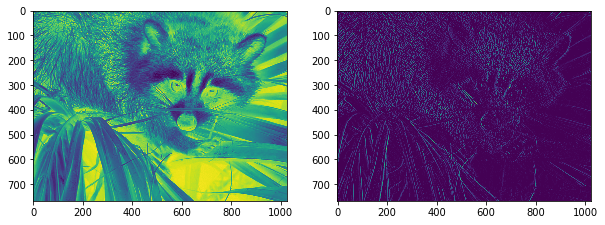

In [1]:
%matplotlib inline
import scipy as sp
from scipy import misc
import numpy as np
import matplotlib.pylab as plt
import scipy.ndimage

# 반전
img = 255 - sp.misc.face(gray=True).astype(float) # 이미지, 동영상
# edge detection filter - 경계선 검출
k = np.zeros((2,2))
k[:,0] = 1
k[:,1] = -1
# convolve 이미지에서 필터, 정보통신 무선신호 복원
img2 = np.maximum(0, sp.ndimage.filters.convolve(img, k))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.subplot(122)
plt.imshow(img2)
plt.grid(False)
plt.show()

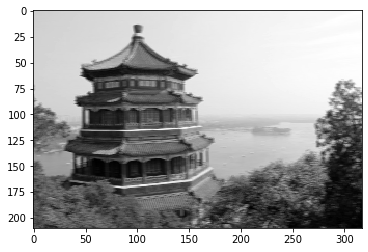

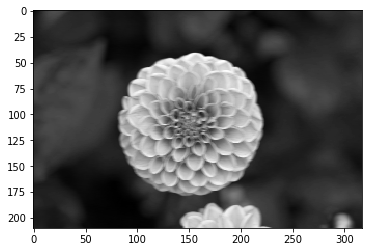

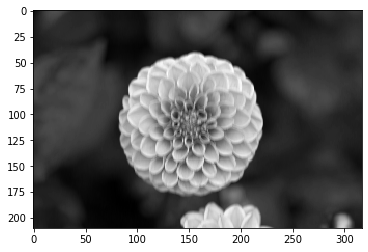

(?, 421, 634, 2)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
import tensorflow as tf
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,1,1,1], padding="SAME")
max_pool = tf.nn.max_pool(convolution, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
# 여기 참고 ksize 는 필터 개념인가봥
# https://bcho.tistory.com/tag/stride
    
with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
plt.imshow(output[0,:,:,1], cmap='gray')
plt.show()
plt.imshow(output[1,:,:,1], cmap='gray')
plt.show()
plt.imshow(output[1,:,:,0], cmap='gray')
plt.show()
type(output)
print(convolution.shape)

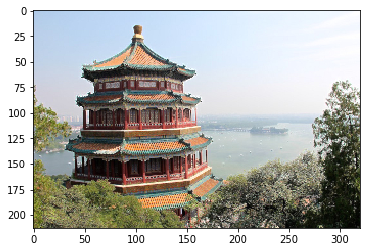

In [29]:
# max pooling 된 결과를 이미지 출력하시오
# conv2d 채널 1개로 생성, max_pool 채널 그대로 남겨둠
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
plt.imshow(output[0].astype(np.uint8)) # unsigned int 형 (양수)
plt.show()

In [12]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')

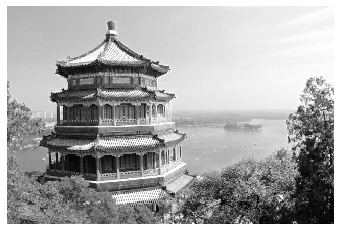

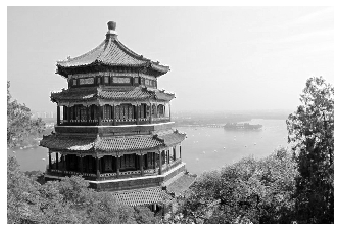

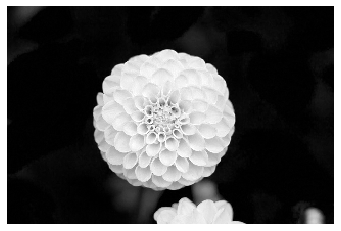

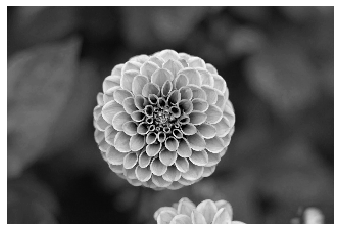

In [24]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


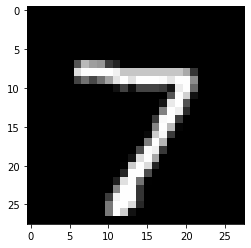

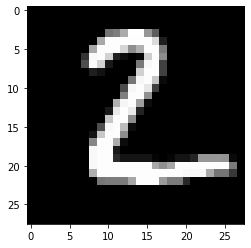

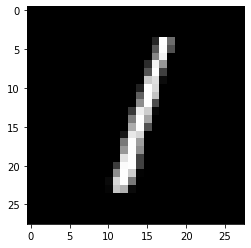

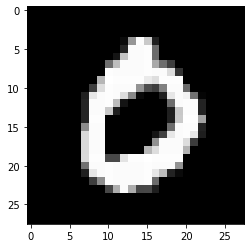

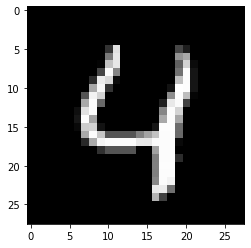

In [8]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
# 5장의 이미지 출력
first_image = mnist.test.images[0:5]
for i in range(5):
    pixels = first_image[i].reshape(28,28)
    plt.imshow(pixels, cmap='gray')
    plt.show()

프로젝트 관련
https://blog.valohai.com/clothes-detection-for-fashion-recommendation

In [9]:
import tensorflow as tf
# 1번 이상 반복되면 함수화
# activation function 마지막에 한번 호출 : 회귀, 분류
# multi-layer : xor 문제 해결은 activation 함수를 이용해서 비선형으로 문제 해결
from tensorflow.python.framework import ops
ops.reset_default_graph()

learning_rate = 0.001 # optimizer 사용
num_steps = 500 # epoch
batch_size = 128 # mini batch size
display_step = 10 # 시각화

num_input = 784 # 이미지 28X28 (fully-connected)
num_classes = 10 # one-hot-encoding
dropout = 0.75 # 과적합 방지를 위해 임의적으로 25% 계산 / 임의적으로 계산

X = tf.placeholder(tf.float32, [None, num_input], name='input')
Y = tf.placeholder(tf.float32, [None, num_classes], name='output')
keep_prob = tf.placeholder(tf.float32, name='keep')

In [10]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) # 비선형 mapping

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k , 1], strides=[1, k, k, 1], padding='SAME')

In [11]:
def conv_net(x, weights, biases, dropout): # 128X784
    x = tf.reshape(x, shape=[-1, 28, 28, 1])# 원래 이미지 형태
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]]) # 128X1024
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    tf1 = tf.nn.dropout(fc1, dropout) # 25% 계산 제외
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) # 128X1024, 1024X10 => 128X10
    return out

In [12]:
weights = {
    'wc1' : tf.Variable(tf.random_normal([5,5,1,32])), #입력 1, 출력 32
    'wc2' : tf.Variable(tf.random_normal([5,5,32,64])),
    'wd1' : tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out' : tf.Variable(tf.random_normal([1024, num_classes]))
}
biases = {
    'bc1' : tf.Variable(tf.random_normal([32])),
    'bc2' : tf.Variable(tf.random_normal([64])),
    'bd1' : tf.Variable(tf.random_normal([1024])),
    'out' : tf.Variable(tf.random_normal([num_classes]))
}

In [13]:
logits = conv_net(X, weights, biases, keep_prob) #128X10
prediction = tf.nn.softmax(logits, name='prediction')
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tf.add_to_collection("accuracy", accuracy)
tf.add_to_collection("Xi", X)
tf.add_to_collection("Yi", Y)
tf.add_to_collection("prediction", prediction)

init = tf.global_variables_initializer()

In [8]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy],
                                feed_dict={X: batch_x, Y:batch_y, keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss) 
                 + ", Training Accuracy= " + "{:.3f}".format(acc))
    print("Testing Accuracy:",
         sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))

Step 1, Minibatch Loss= 78272.1719, Training Accuracy= 0.078
Step 10, Minibatch Loss= 27314.0742, Training Accuracy= 0.281
Step 20, Minibatch Loss= 11496.7793, Training Accuracy= 0.445
Step 30, Minibatch Loss= 5807.1499, Training Accuracy= 0.617
Step 40, Minibatch Loss= 4137.8115, Training Accuracy= 0.773
Step 50, Minibatch Loss= 3520.8999, Training Accuracy= 0.781
Step 60, Minibatch Loss= 3875.6943, Training Accuracy= 0.781
Step 70, Minibatch Loss= 2753.5408, Training Accuracy= 0.812
Step 80, Minibatch Loss= 2262.4863, Training Accuracy= 0.797
Step 90, Minibatch Loss= 1634.1692, Training Accuracy= 0.852
Step 100, Minibatch Loss= 2023.5026, Training Accuracy= 0.844
Step 110, Minibatch Loss= 1732.5928, Training Accuracy= 0.859
Step 120, Minibatch Loss= 2329.8794, Training Accuracy= 0.797
Step 130, Minibatch Loss= 1999.7844, Training Accuracy= 0.883
Step 140, Minibatch Loss= 1583.1218, Training Accuracy= 0.844
Step 150, Minibatch Loss= 2127.6289, Training Accuracy= 0.828
Step 160, Miniba

KeyboardInterrupt: 

# 테스트 데이터 100번부터 20개의 데이터를 예측해보시오
- 예측된 데이터를 출력해보시오

In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy],
                                feed_dict={X: batch_x, Y:batch_y, keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss) 
                 + ", Training Accuracy= " + "{:.3f}".format(acc))
    save_path = saver.save(sess, 'data/cnn_model.ckpt', global_step=1000)
    print("예측:",
         sess.run(tf.argmax(prediction,1), feed_dict={X: mnist.test.images[100:120],
                                      Y: mnist.test.labels[100:120],
                                      keep_prob: 1.0}))

Step 1, Minibatch Loss= 54510.4531, Training Accuracy= 0.094
Step 10, Minibatch Loss= 28037.6953, Training Accuracy= 0.211
Step 20, Minibatch Loss= 8901.3105, Training Accuracy= 0.492
Step 30, Minibatch Loss= 4407.2148, Training Accuracy= 0.656
Step 40, Minibatch Loss= 4288.6641, Training Accuracy= 0.711
Step 50, Minibatch Loss= 4788.0684, Training Accuracy= 0.734
Step 60, Minibatch Loss= 2178.3909, Training Accuracy= 0.820
Step 70, Minibatch Loss= 3704.2710, Training Accuracy= 0.758
Step 80, Minibatch Loss= 1350.2776, Training Accuracy= 0.844
Step 90, Minibatch Loss= 2323.5803, Training Accuracy= 0.828
Step 100, Minibatch Loss= 2027.3994, Training Accuracy= 0.883
Step 110, Minibatch Loss= 1495.0112, Training Accuracy= 0.898
Step 120, Minibatch Loss= 2200.0801, Training Accuracy= 0.820
Step 130, Minibatch Loss= 1623.7283, Training Accuracy= 0.883
Step 140, Minibatch Loss= 1430.7621, Training Accuracy= 0.875
Step 150, Minibatch Loss= 897.1152, Training Accuracy= 0.898
Step 160, Minibatc

In [22]:
import tensorflow as tf
tf.set_random_seed(777)
sess = tf.InteractiveSession()
new_saver = tf.train.import_meta_graph('data/cnn_model.ckpt-1000.meta')
new_saver.restore(sess, 'data/cnn_model.ckpt-1000')
tf.get_default_graph()
Xi = sess.graph.get_tensor_by_name("input:0") # : 뒤에 붙는 건 장치번호
Yi = sess.graph.get_tensor_by_name("output:0")
keep = sess.graph.get_tensor_by_name("keep:0")
accuracy = sess.graph.get_tensor_by_name("accuracy:0")
result = sess.run(accuracy, feed_dict={Xi: mnist.test.images[:256], Yi: mnist.test.labels[:256], keep:1.0})
print(result)

INFO:tensorflow:Restoring parameters from data/cnn_model.ckpt-1000
0.953125


In [ ]:
# 저장된 모델을 로딩한 다음 테스트 데이터 100번부터 20개의 데이터를 예측하여 출력하고 정확도를 출력하시오.

In [24]:
sess = tf.InteractiveSession()
new_saver = tf.train.import_meta_graph('data/cnn_model.ckpt-1000.meta')
new_saver.restore(sess, 'data/cnn_model.ckpt-1000')
tf.get_default_graph()
Xi = sess.graph.get_tensor_by_name("input:0") # : 뒤에 붙는 건 장치번호
Yi = sess.graph.get_tensor_by_name("output:0")
keep = sess.graph.get_tensor_by_name("keep:0")
accuracy = sess.graph.get_tensor_by_name("accuracy:0")
prediction = sess.graph.get_tensor_by_name("prediction:0")
result = sess.run(tf.argmax(prediction,1), feed_dict={Xi: mnist.test.images[100:120], Yi: mnist.test.labels[100:120], keep:1.0})
print(result)

# 정신을 차리시오.... @_@ 헤로옹
# https://goodtogreate.tistory.com/entry/Saving-and-Restoring

INFO:tensorflow:Restoring parameters from data/cnn_model.ckpt-1000
[6 0 5 4 9 9 2 1 9 4 8 7 3 9 7 4 4 4 4 2]
